In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [6]:
# Load the dataset
data = pd.read_excel(r"C:\Users\itxme\Desktop\week 2\dataset\Online Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [9]:
# Ensure InvoiceDate is a datetime column
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# Define the latest date in the dataset
latest_date = data['InvoiceDate'].max()

# Recency: Days since the last purchase
rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',  # Frequency: Total number of invoices
    'Quantity': lambda x: (x * data.loc[x.index, 'UnitPrice']).sum()  # Monetary
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Remove negative or zero monetary values
rfm = rfm[rfm['Monetary'] > 0]

print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
1     12347.0        1        182   4310.00
2     12348.0       74         31   1797.24
3     12349.0       18         73   1757.55
4     12350.0      309         17    334.40
5     12352.0       35         95   1545.41


In [10]:
# Normalize RFM using Min-Max Scaling
scaler = MinMaxScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
print(rfm_scaled.head())

    Recency  Frequency  Monetary
0  0.002681   0.022676  0.015421
1  0.198391   0.003758  0.006430
2  0.048257   0.009020  0.006288
3  0.828418   0.002005  0.001196
4  0.093834   0.011776  0.005529


C:\Users\itxme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\itxme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\itxme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\itxme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

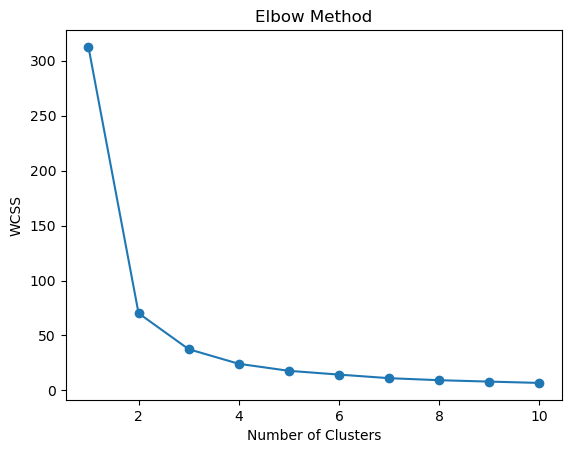

In [11]:
# Use Elbow Method
wcss = []  # Within-cluster sum of squares
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [12]:
# Based on Elbow Method, choose the optimal number of clusters (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.head())

C:\Users\itxme\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


   CustomerID  Recency  Frequency  Monetary  Cluster
1     12347.0        1        182   4310.00        0
2     12348.0       74         31   1797.24        3
3     12349.0       18         73   1757.55        0
4     12350.0      309         17    334.40        1
5     12352.0       35         95   1545.41        0


In [13]:
# Apply DBSCAN
dbscan = DBSCAN(eps=0.2, min_samples=5)  # Adjust eps and min_samples as needed
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)

print(rfm['DBSCAN_Cluster'].value_counts())

DBSCAN_Cluster
 0    4313
-1       7
Name: count, dtype: int64


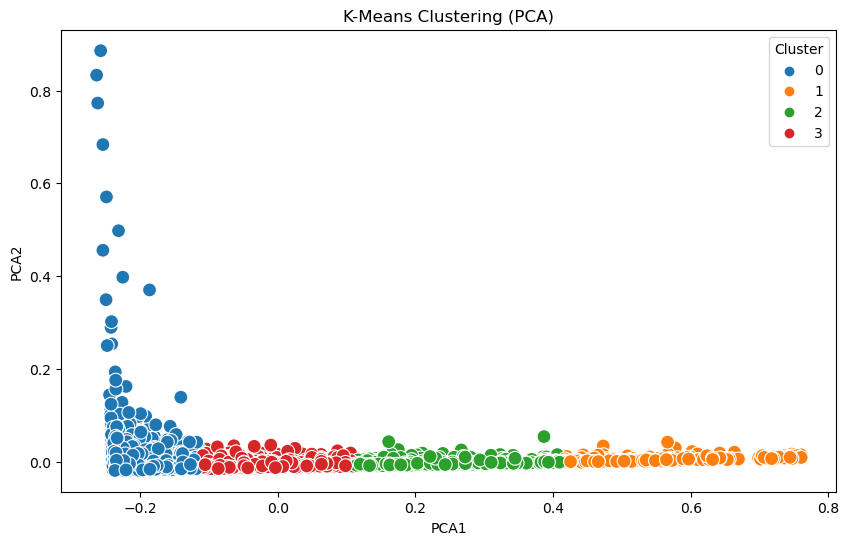

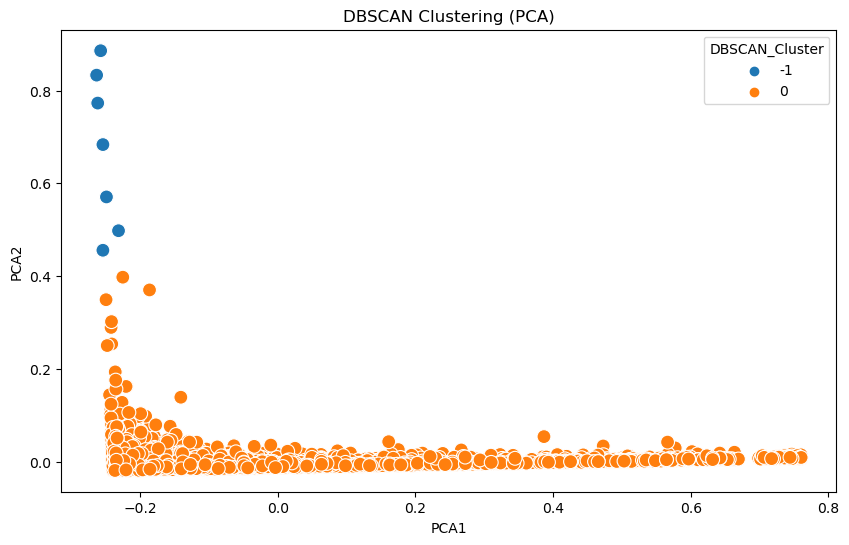

In [14]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(rfm_scaled)

# Convert to DataFrame
rfm['PCA1'] = pca_result[:, 0]
rfm['PCA2'] = pca_result[:, 1]

# Plot K-Means Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='Cluster', palette='tab10', s=100)
plt.title('K-Means Clustering (PCA)')
plt.show()

# Plot DBSCAN Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10', s=100)
plt.title('DBSCAN Clustering (PCA)')
plt.show()

In [15]:
# Analyze each cluster
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

print(cluster_summary)

# Suggest marketing strategies for each cluster
for cluster in cluster_summary['Cluster']:
    print(f"Cluster {cluster}:")
    if cluster == 0:  # Example cluster condition
        print("High Recency, Low Frequency, Low Monetary: Recommend re-engagement campaigns.")
    elif cluster == 1:
        print("Low Recency, High Frequency, High Monetary: Focus on loyalty rewards.")
    # Add more insights based on your data.

   Cluster     Recency   Frequency     Monetary
0        0   17.377499  146.730823  3108.349917
1        1  303.370809   24.126233   392.041183
2        2  185.003279   35.931148   618.099821
3        3   77.941065   53.750951   999.456760
Cluster 0:
High Recency, Low Frequency, Low Monetary: Recommend re-engagement campaigns.
Cluster 1:
Low Recency, High Frequency, High Monetary: Focus on loyalty rewards.
Cluster 2:
Cluster 3:
